In [126]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
%matplotlib inline 

In [69]:
# to see all the columns when using head() or describe()
pd.set_option('display.max_columns',60)

In [85]:
df = pd.read_csv("diaries_trx_trunc_loans.csv", dtype={'account_startclose_balance': str,"account_ids":str, "new_account_ids":str})

### Let's add a column to df that contains the information about the balance evolution. We just reuse the previous algorithm for this.

In [86]:
#add balance evolution to original dataset
df.insert(df.shape[1],"bal_evol",np.zeros(df.shape[0]))

In [87]:
#add column for starting balance 
df.insert(df.shape[1],"start_bal",np.zeros(df.shape[0]))

In [97]:
exc = set()
for acc in df["new_account_ids"].unique():
    lna = df[df["new_account_ids"]==acc]
    #we want the lna dataset with the new borrowing the first entry of the first day
    #we reuse the algorithm from the truncation program.
    # sort the dataset according to time
    i=0
    # we will use "indices" to save the reordered indices of the dataset for each unique loan
    indices = []
    # we will use "index_bor" to save the index of the new borrowing that happens on a given day,
    #whenever there were also other transactions (since we need that index to be first)
    index_bor = 0
    # sort the dataset according to time
    lna = lna.sort_values("trx_stdtime_days_acc")
    # for each day in the dataset of the account, we check whether there was 
    # a new borrowing or starting balance and if yes reorder
    for d in lna["trx_stdtime_days_acc"].unique():
        # if only one entry that day we just add the index to indices
        if lna[lna["trx_stdtime_days_acc"]==d].shape[0]==1:
            indices.append(lna[lna["trx_stdtime_days_acc"]==d].index[0])
        # if there are more than 1 entry that day
        elif lna[lna["trx_stdtime_days_acc"]==d].shape[0]>1:
            # if there are more than one new borrowings or starting balances, we need to check manually
            if lna[(lna["trx_stdtime_days_acc"]==d)&((lna["trx_prx_purpose"]=="2. New borrowing")|(lna["trx_prx_purpose"]=="2. New borrowinng (individual portion)")|(lna["trx_prx_purpose"]=="1. Starting balance (today)"))].shape[0]>1:
                print("Several new borrowings on day " + str(d) +", check manually account " + acc + " in category "+ str(lna["trx_type_code"].unique()))
            #if there is exactly one new borrowing or starting balance that day (here we will need to check for each loan type what they exactly call new borrowings)
            elif lna[(lna["trx_stdtime_days_acc"]==d)&((lna["trx_prx_purpose"]=="2. New borrowing")|(lna["trx_prx_purpose"]=="2. New borrowinng (individual portion)")|(lna["trx_prx_purpose"]=="1. Starting balance (today)"))].shape[0]==1:
                #for each type of new borrowing if there is one that day, put that index first into indices
                for kind in ["2. New borrowing","2. New borrowinng (individual portion)","1. Starting balance (today)"]:
                    if kind in lna[lna["trx_stdtime_days_acc"]==d]["trx_prx_purpose"].unique():
                        index_bor = lna[(lna["trx_stdtime_days_acc"]==d) & (lna["trx_prx_purpose"]==kind)].index[0]
                        indices.append(index_bor)
                        #then add all other indices of that day
                        for i in lna[lna["trx_stdtime_days_acc"]==d].index.drop(index_bor):
                            indices.append(i)
            # if there are several entries for that day but none of them new borrowings just add all indices of that day            
            else:
                for i in lna[lna["trx_stdtime_days_acc"]==d].index:
                    indices.append(i)
    # here we reindex the lna dataset
    lna = lna.loc[indices,]
    
    #add transaction with direction for account
    lna.insert(58, "trx_val_dir",np.zeros(lna.shape[0]))
    for index, row in lna.iterrows():
        if lna.loc[index,"trx_bsheet_direction"]=="Increase":
            lna.at[index,"trx_val_dir"] = lna.loc[index,"trx_value_kes"]
        elif lna.loc[index,"trx_bsheet_direction"]=="Decrease":
            lna.at[index,"trx_val_dir"] = -lna.loc[index,"trx_value_kes"]
        else:
            #save where there is neither increase nor decrease
            exc.add(row["trx_prx_purpose"])
    
    #add the balance evolution entries to df 
    s=0
    start_bal = lna.iloc[0,df.columns.get_loc("trx_value_kes")]
    for index,row in lna.iterrows():
        s+=lna.loc[index,"trx_val_dir"]
        df.at[index,"bal_evol"]=s
        df.at[index,"start_bal"]=start_bal
    #add the starting balance to df
    
    

In [89]:
exc

{'6. Closing Balance--End of last DQ',
 '7. Closing Balance--End of last DQ',
 '7. Refund from lender'}

### The refund from lender seems to be a bit misterious, maybe we should also exclude that.

In [90]:
df["trx_prx_purpose"].value_counts()

3. Payments                               1017
2. New borrowing                           223
5. Interest accruing                       202
1. Starting balance (today)                130
7. Closing Balance--End of last DQ         126
6. Closing Balance--End of last DQ          69
4. Any known fees                           26
2. New borrowinng (individual portion)       4
7. Refund from lender                        1
Name: trx_prx_purpose, dtype: int64

In [91]:
df[df["trx_prx_purpose"]=="7. Refund from lender"]

,Unnamed: 0,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,new_account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,...,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,acc_unexplained_trx,bal_evol,start_bal
575,38535,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708620100000,59134381215900000,01aug2013,8,...,352,12,198,6,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,7. Refund from lender,NaN,0.0,NaN,10.0,"In-kind (trade, good, service--NOT MONEY)",1.0,0.0,07=Group meeting,Inflow,300.0,3.529412,0,panga,3.529412,300.0,12.13793,0.0,2500.0,0.0


In [92]:
df[df["account_ids"]=="59136376033300000"].sort_values("trx_stdtime_days_acc")

,Unnamed: 0,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,new_account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,...,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,acc_unexplained_trx,bal_evol,start_bal
864,177769,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708585300000,59134381215900000,15jan2013,1,...,154,5,0,0,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,2. New borrowing,New borrowing on financial liability,0.0,Increase,10.0,"In-kind (trade, good, service--NOT MONEY)",1.0,0.0,"01=Bank, MFI, SACCO, insurance branch",Inflow,9500.0,111.764700,0,"Farm inputs, solar lamp",111.764700,9500.0,5.310345,0.0,9500.0,0.0
934,212912,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708599100000,59134381215900000,18jan2013,1,...,157,5,3,0,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,3. Payments,Repayment on financial liability,0.0,Decrease,1.0,Cash,1.0,0.0,07=Group meeting,Outflow,200.0,2.352941,0,NaN,NaN,NaN,5.413793,0.0,9300.0,0.0
1289,342023,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708599100000,59134381215900000,25jan2013,1,...,164,5,10,0,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,3. Payments,Repayment on financial liability,0.0,Decrease,1.0,Cash,1.0,0.0,07=Group meeting,Outflow,200.0,2.352941,0,NaN,NaN,NaN,5.655172,0.0,9100.0,0.0
1070,257713,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708594100000,59134381215900000,01feb2013,2,...,171,5,17,0,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,3. Payments,Repayment on financial liability,0.0,Decrease,1.0,Cash,1.0,0.0,07=Group meeting,Outflow,500.0,5.882353,0,NaN,NaN,NaN,5.896552,0.0,8600.0,0.0
1118,281215,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708599100000,59134381215900000,15mar2013,3,...,213,7,59,2,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,3. Payments,Repayment on financial liability,0.0,Decrease,1.0,Cash,1.0,0.0,07=Group meeting,Outflow,210.0,2.470588,0,NaN,NaN,NaN,7.344828,0.0,8390.0,0.0
1071,257715,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,59136376033300000.1,NaN,5913438121590000

### I think that we can keep this loan as is, by just ignoring the "refund from lender" transaction.

# Checking if it worked properly.

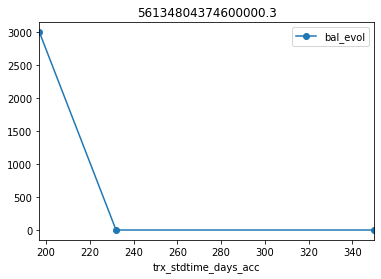

56134804374600000.3


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1301,INFGRP,Borrowing from an informal Group,197,2. New borrowing,3000.0,3000.0,3000.0
790,INFGRP,Borrowing from an informal Group,232,3. Payments,3000.0,0.0,3000.0
0,INFGRP,Borrowing from an informal Group,350,7. Closing Balance--End of last DQ,0.0,0.0,3000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
353,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),30000.0,30000.0,30000.0
1299,INFGRP,Borrowing from an informal Group,36,3. Payments,30000.0,0.0,30000.0
914,INFGRP,Borrowing from an informal Group,49,2. New borrowing,4000.0,4000.0,4000.0
1396,INFGRP,Borrowing from an informal Group,56,3. Payments,1200.0,2800.0,4000.0
1300,INFGRP,Borrowing from an informal Group,195,3. Payments,2800.0,0.0,4000.0
1301,INFGRP,Borrowing from an informal Group,197,2. New borrowing,3000.0,3000.0,3000.0
790,INFGRP,Borrowing from an informal Group,232,3. Payments,3000.0,0.0,3000.0
0,INFGRP,Borrowing from an informal Group,350,7. Closing Balance--End of last DQ,0.0,0.0,3000.0


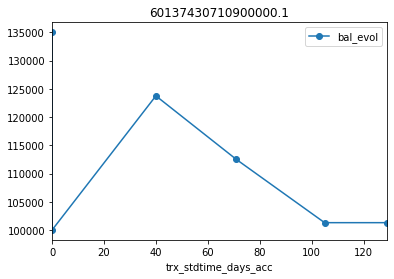

60137430710900000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
185,FRMLN,Individual Business or Agriculture Loan,0,5. Interest accruing,35000.0,135000.0,100000.0
1435,FRMLN,Individual Business or Agriculture Loan,0,2. New borrowing,100000.0,100000.0,100000.0
744,FRMLN,Individual Business or Agriculture Loan,40,3. Payments,11250.0,123750.0,100000.0
861,FRMLN,Individual Business or Agriculture Loan,71,3. Payments,11250.0,112500.0,100000.0
1169,FRMLN,Individual Business or Agriculture Loan,105,3. Payments,11200.0,101300.0,100000.0
1,FRMLN,Individual Business or Agriculture Loan,129,6. Closing Balance--End of last DQ,101300.0,101300.0,100000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
185,FRMLN,Individual Business or Agriculture Loan,0,5. Interest accruing,35000.0,135000.0,100000.0
1435,FRMLN,Individual Business or Agriculture Loan,0,2. New borrowing,100000.0,100000.0,100000.0
744,FRMLN,Individual Business or Agriculture Loan,40,3. Payments,11250.0,123750.0,100000.0
861,FRMLN,Individual Business or Agriculture Loan,71,3. Payments,11250.0,112500.0,100000.0
1169,FRMLN,Individual Business or Agriculture Loan,105,3. Payments,11200.0,101300.0,100000.0
1,FRMLN,Individual Business or Agriculture Loan,129,6. Closing Balance--End of last DQ,101300.0,101300.0,100000.0


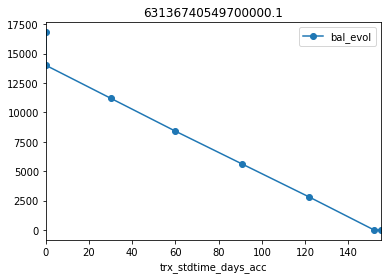

63136740549700000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
2,FRMLN,Consumer/ personal loan (not payday loan),0,1. Starting balance (today),16800.0,16800.0,16800.0
1381,FRMLN,Consumer/ personal loan (not payday loan),0,3. Payments,2800.0,14000.0,16800.0
1100,FRMLN,Consumer/ personal loan (not payday loan),30,3. Payments,2800.0,11200.0,16800.0
616,FRMLN,Consumer/ personal loan (not payday loan),60,3. Payments,2800.0,8400.0,16800.0
1382,FRMLN,Consumer/ personal loan (not payday loan),91,3. Payments,2800.0,5600.0,16800.0
990,FRMLN,Consumer/ personal loan (not payday loan),122,3. Payments,2800.0,2800.0,16800.0
911,FRMLN,Consumer/ personal loan (not payday loan),152,3. Payments,2800.0,0.0,16800.0
44,FRMLN,Consumer/ personal loan (not payday loan),155,6. Closing Balance--End of last DQ,0.0,0.0,16800.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
2,FRMLN,Consumer/ personal loan (not payday loan),0,1. Starting balance (today),16800.0,16800.0,16800.0
1381,FRMLN,Consumer/ personal loan (not payday loan),0,3. Payments,2800.0,14000.0,16800.0
1100,FRMLN,Consumer/ personal loan (not payday loan),30,3. Payments,2800.0,11200.0,16800.0
616,FRMLN,Consumer/ personal loan (not payday loan),60,3. Payments,2800.0,8400.0,16800.0
1382,FRMLN,Consumer/ personal loan (not payday loan),91,3. Payments,2800.0,5600.0,16800.0
990,FRMLN,Consumer/ personal loan (not payday loan),122,3. Payments,2800.0,2800.0,16800.0
911,FRMLN,Consumer/ personal loan (not payday loan),152,3. Payments,2800.0,0.0,16800.0
44,FRMLN,Consumer/ personal loan (not payday loan),155,6. Closing Balance--End of last DQ,0.0,0.0,16800.0


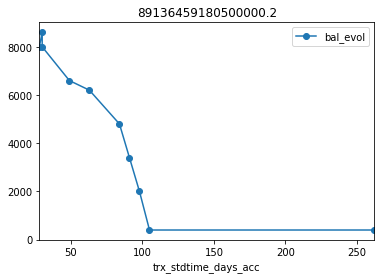

89136459180500000.2


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1018,INFGRP,Borrowing from an informal Group,28,2. New borrowing,8000.0,8000.0,8000.0
3,INFGRP,Borrowing from an informal Group,30,5. Interest accruing,600.0,8600.0,8000.0
1332,INFGRP,Borrowing from an informal Group,30,3. Payments,600.0,8000.0,8000.0
907,INFGRP,Borrowing from an informal Group,49,3. Payments,1400.0,6600.0,8000.0
1475,INFGRP,Borrowing from an informal Group,63,3. Payments,400.0,6200.0,8000.0
932,INFGRP,Borrowing from an informal Group,84,3. Payments,1400.0,4800.0,8000.0
903,INFGRP,Borrowing from an informal Group,91,3. Payments,1400.0,3400.0,8000.0
1237,INFGRP,Borrowing from an informal Group,98,3. Payments,1400.0,2000.0,8000.0
756,INFGRP,Borrowing from an informal Group,105,3. Payments,1600.0,400.0,8000.0
247,INFGRP,Borrowing from an informal Group,262,7. Closing Balance--End of last DQ,0.0,400.0,8000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
615,INFGRP,Borrowing from an informal Group,0,2. New borrowing,8000.0,8000.0,8000.0
890,INFGRP,Borrowing from an informal Group,0,3. Payments,8400.0,-400.0,8000.0
1018,INFGRP,Borrowing from an informal Group,28,2. New borrowing,8000.0,8000.0,8000.0
3,INFGRP,Borrowing from an informal Group,30,5. Interest accruing,600.0,8600.0,8000.0
1332,INFGRP,Borrowing from an informal Group,30,3. Payments,600.0,8000.0,8000.0
907,INFGRP,Borrowing from an informal Group,49,3. Payments,1400.0,6600.0,8000.0
1475,INFGRP,Borrowing from an informal Group,63,3. Payments,400.0,6200.0,8000.0
932,INFGRP,Borrowing from an informal Group,84,3. Payments,1400.0,4800.0,8000.0
903,INFGRP,Borrowing from an informal Group,91,3. Payments,1400.0,3400.0,8000.0
1237,INFGRP,Borrowing from an informal Group,98,3. Payments,1400.0,2000.0,8000.0


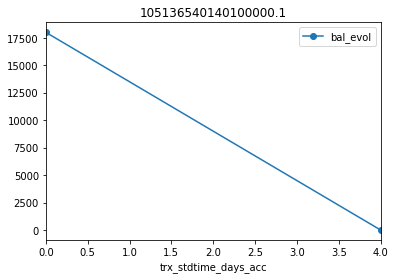

105136540140100000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
4,FRMLN,Individual Business or Agriculture Loan,0,1. Starting balance (today),18000.0,18000.0,18000.0
297,FRMLN,Individual Business or Agriculture Loan,4,3. Payments,18000.0,0.0,18000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
4,FRMLN,Individual Business or Agriculture Loan,0,1. Starting balance (today),18000.0,18000.0,18000.0
297,FRMLN,Individual Business or Agriculture Loan,4,3. Payments,18000.0,0.0,18000.0
1517,FRMLN,Individual Business or Agriculture Loan,18,2. New borrowing,60000.0,60000.0,60000.0
1700,FRMLN,Individual Business or Agriculture Loan,78,3. Payments,5000.0,55000.0,60000.0
1696,FRMLN,Individual Business or Agriculture Loan,108,3. Payments,5000.0,50000.0,60000.0
1694,FRMLN,Individual Business or Agriculture Loan,139,3. Payments,5000.0,45000.0,60000.0
1697,FRMLN,Individual Business or Agriculture Loan,170,3. Payments,5000.0,40000.0,60000.0
413,FRMLN,Individual Business or Agriculture Loan,191,6. Closing Balance--End of last DQ,35000.0,40000.0,60000.0
1695,FRMLN,Individual Business or Agriculture Loan,200,3. Payments,5000.0,35000.0,60000.0


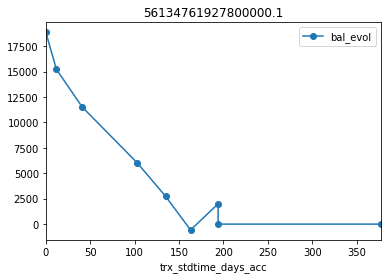

56134761927800000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
517,FRMLN,Individual Business or Agriculture Loan,0,1. Starting balance (today),18870.0,18870.0,18870.0
1529,FRMLN,Individual Business or Agriculture Loan,12,3. Payments,3650.0,15220.0,18870.0
1530,FRMLN,Individual Business or Agriculture Loan,41,3. Payments,3700.0,11520.0,18870.0
1699,FRMLN,Individual Business or Agriculture Loan,103,3. Payments,5500.0,6020.0,18870.0
936,FRMLN,Individual Business or Agriculture Loan,135,3. Payments,3300.0,2720.0,18870.0
1294,FRMLN,Individual Business or Agriculture Loan,163,3. Payments,3300.0,-580.0,18870.0
5,FRMLN,Individual Business or Agriculture Loan,194,5. Interest accruing,2580.0,2000.0,18870.0
1183,FRMLN,Individual Business or Agriculture Loan,194,3. Payments,2000.0,0.0,18870.0
27,FRMLN,Individual Business or Agriculture Loan,377,6. Closing Balance--End of last DQ,0.0,0.0,18870.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
517,FRMLN,Individual Business or Agriculture Loan,0,1. Starting balance (today),18870.0,18870.0,18870.0
1529,FRMLN,Individual Business or Agriculture Loan,12,3. Payments,3650.0,15220.0,18870.0
1530,FRMLN,Individual Business or Agriculture Loan,41,3. Payments,3700.0,11520.0,18870.0
1699,FRMLN,Individual Business or Agriculture Loan,103,3. Payments,5500.0,6020.0,18870.0
936,FRMLN,Individual Business or Agriculture Loan,135,3. Payments,3300.0,2720.0,18870.0
1294,FRMLN,Individual Business or Agriculture Loan,163,3. Payments,3300.0,-580.0,18870.0
5,FRMLN,Individual Business or Agriculture Loan,194,5. Interest accruing,2580.0,2000.0,18870.0
1183,FRMLN,Individual Business or Agriculture Loan,194,3. Payments,2000.0,0.0,18870.0
27,FRMLN,Individual Business or Agriculture Loan,377,6. Closing Balance--End of last DQ,0.0,0.0,18870.0


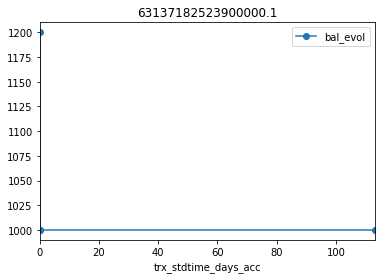

63137182523900000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
6,INFGRP,Borrowing from an informal Group,0,5. Interest accruing,200.0,1200.0,1000.0
1137,INFGRP,Borrowing from an informal Group,0,2. New borrowing,1000.0,1000.0,1000.0
1363,INFGRP,Borrowing from an informal Group,0,3. Payments,200.0,1000.0,1000.0
498,INFGRP,Borrowing from an informal Group,113,7. Closing Balance--End of last DQ,1000.0,1000.0,1000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
6,INFGRP,Borrowing from an informal Group,0,5. Interest accruing,200.0,1200.0,1000.0
1137,INFGRP,Borrowing from an informal Group,0,2. New borrowing,1000.0,1000.0,1000.0
1363,INFGRP,Borrowing from an informal Group,0,3. Payments,200.0,1000.0,1000.0
498,INFGRP,Borrowing from an informal Group,113,7. Closing Balance--End of last DQ,1000.0,1000.0,1000.0


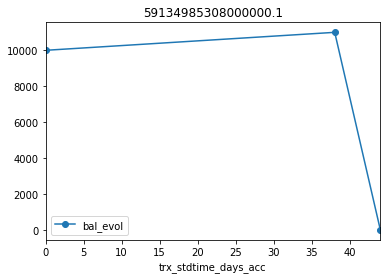

59134985308000000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
379,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),10000.0,10000.0,10000.0
7,INFGRP,Borrowing from an informal Group,38,5. Interest accruing,1000.0,11000.0,10000.0
1463,INFGRP,Borrowing from an informal Group,44,3. Payments,11000.0,0.0,10000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
379,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),10000.0,10000.0,10000.0
7,INFGRP,Borrowing from an informal Group,38,5. Interest accruing,1000.0,11000.0,10000.0
1463,INFGRP,Borrowing from an informal Group,44,3. Payments,11000.0,0.0,10000.0
1049,INFGRP,Borrowing from an informal Group,207,2. New borrowing,1000.0,1000.0,1000.0
338,INFGRP,Borrowing from an informal Group,221,5. Interest accruing,200.0,1200.0,1000.0
447,INFGRP,Borrowing from an informal Group,252,5. Interest accruing,200.0,1400.0,1000.0
380,INFGRP,Borrowing from an informal Group,283,5. Interest accruing,200.0,1600.0,1000.0
186,INFGRP,Borrowing from an informal Group,315,7. Closing Balance--End of last DQ,1600.0,1600.0,1000.0


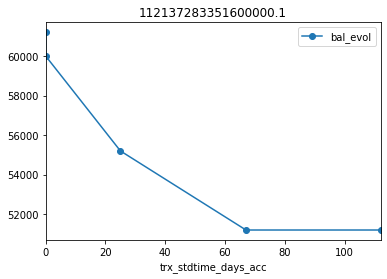

112137283351600000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
442,FRMLN,Joint liability loan,0,4. Any known fees,1200.0,61200.0,60000.0
1583,FRMLN,Joint liability loan,0,2. New borrowinng (individual portion),60000.0,60000.0,60000.0
991,FRMLN,Joint liability loan,25,3. Payments,6000.0,55200.0,60000.0
1235,FRMLN,Joint liability loan,67,3. Payments,4000.0,51200.0,60000.0
8,FRMLN,Joint liability loan,112,6. Closing Balance--End of last DQ,51200.0,51200.0,60000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
442,FRMLN,Joint liability loan,0,4. Any known fees,1200.0,61200.0,60000.0
1583,FRMLN,Joint liability loan,0,2. New borrowinng (individual portion),60000.0,60000.0,60000.0
991,FRMLN,Joint liability loan,25,3. Payments,6000.0,55200.0,60000.0
1235,FRMLN,Joint liability loan,67,3. Payments,4000.0,51200.0,60000.0
8,FRMLN,Joint liability loan,112,6. Closing Balance--End of last DQ,51200.0,51200.0,60000.0


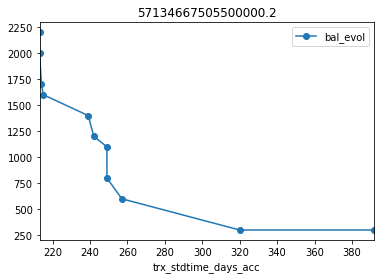

57134667505500000.2


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
94,INFGRP,Borrowing from an informal Group,213,5. Interest accruing,200.0,2200.0,2000.0
1147,INFGRP,Borrowing from an informal Group,213,2. New borrowing,2000.0,2000.0,2000.0
1213,INFGRP,Borrowing from an informal Group,214,3. Payments,500.0,1700.0,2000.0
849,INFGRP,Borrowing from an informal Group,215,3. Payments,100.0,1600.0,2000.0
1478,INFGRP,Borrowing from an informal Group,239,3. Payments,200.0,1400.0,2000.0
1163,INFGRP,Borrowing from an informal Group,242,3. Payments,200.0,1200.0,2000.0
57,INFGRP,Borrowing from an informal Group,249,3. Payments,100.0,1100.0,2000.0
879,INFGRP,Borrowing from an informal Group,249,3. Payments,300.0,800.0,2000.0
832,INFGRP,Borrowing from an informal Group,257,3. Payments,200.0,600.0,2000.0
1220,INFGRP,Borrowing from an informal Group,320,3. Payments,300.0,300.0,2000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
477,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),550.0,550.0,550.0
764,INFGRP,Borrowing from an informal Group,3,3. Payments,500.0,50.0,550.0
94,INFGRP,Borrowing from an informal Group,213,5. Interest accruing,200.0,2200.0,2000.0
1147,INFGRP,Borrowing from an informal Group,213,2. New borrowing,2000.0,2000.0,2000.0
1213,INFGRP,Borrowing from an informal Group,214,3. Payments,500.0,1700.0,2000.0
849,INFGRP,Borrowing from an informal Group,215,3. Payments,100.0,1600.0,2000.0
1478,INFGRP,Borrowing from an informal Group,239,3. Payments,200.0,1400.0,2000.0
1163,INFGRP,Borrowing from an informal Group,242,3. Payments,200.0,1200.0,2000.0
57,INFGRP,Borrowing from an informal Group,249,3. Payments,100.0,1100.0,2000.0
879,INFGRP,Borrowing from an informal Group,249,3. Payments,300.0,800.0,2000.0


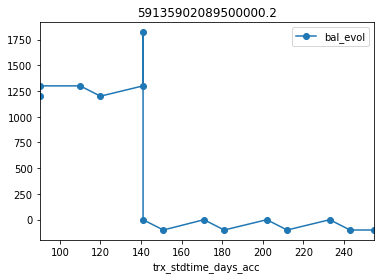

59135902089500000.2


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
825,INFGRP,Borrowing from an informal Group,90,3. Payments,100.0,1200.0,1300.0
1499,INFGRP,Borrowing from an informal Group,90,2. New borrowing,1300.0,1300.0,1300.0
493,INFGRP,Borrowing from an informal Group,110,5. Interest accruing,100.0,1300.0,1300.0
1177,INFGRP,Borrowing from an informal Group,120,3. Payments,100.0,1200.0,1300.0
275,INFGRP,Borrowing from an informal Group,141,5. Interest accruing,100.0,1300.0,1300.0
321,INFGRP,Borrowing from an informal Group,141,5. Interest accruing,520.0,1820.0,1300.0
1065,INFGRP,Borrowing from an informal Group,141,3. Payments,1820.0,0.0,1300.0
1066,INFGRP,Borrowing from an informal Group,151,3. Payments,100.0,-100.0,1300.0
358,INFGRP,Borrowing from an informal Group,171,5. Interest accruing,100.0,0.0,1300.0
632,INFGRP,Borrowing from an informal Group,181,3. Payments,100.0,-100.0,1300.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
264,INFGRP,Borrowing from an informal Group,0,5. Interest accruing,100.0,600.0,500.0
1415,INFGRP,Borrowing from an informal Group,0,2. New borrowing,500.0,500.0,500.0
1194,INFGRP,Borrowing from an informal Group,0,3. Payments,100.0,500.0,500.0
519,INFGRP,Borrowing from an informal Group,21,5. Interest accruing,100.0,600.0,500.0
1326,INFGRP,Borrowing from an informal Group,31,3. Payments,100.0,500.0,500.0
108,INFGRP,Borrowing from an informal Group,49,5. Interest accruing,100.0,600.0,500.0
1064,INFGRP,Borrowing from an informal Group,59,3. Payments,100.0,500.0,500.0
150,INFGRP,Borrowing from an informal Group,80,5. Interest accruing,100.0,600.0,500.0
1499,INFGRP,Borrowing from an informal Group,90,2. New borrowing,1300.0,1300.0,1300.0
825,INFGRP,Borrowing from an informal Group,90,3. Payments,100.0,1200.0,1300.0


In [98]:
count = 0
for acc in df["new_account_ids"].unique():
    df[df["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc").plot(x="trx_stdtime_days_acc",y="bal_evol", title = acc,marker="o")
    plt.show()
    print(acc)
    display(df[df["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])
    display(df[df["account_ids"]==acc[:-2]].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])
    count +=1
    if count > 10:
        break

In [112]:
st_b=[]
print(st_b)
for acc in df["new_account_ids"].unique():
    if len(df[df["new_account_ids"]==acc]["start_bal"].unique())==1:
        st_b.append(df[df["new_account_ids"]==acc]["start_bal"].unique()[0])
    else:
        print("Error")
st_b[0:10]

[]


[3000.0,
 100000.0,
 16800.0,
 8000.0,
 18000.0,
 18870.0,
 1000.0,
 10000.0,
 60000.0,
 2000.0]

In [134]:
stats.percentileofscore(st_b,200)

6.052631578947368

In [129]:
np.quantile(st_b,0.4)

2000.0

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


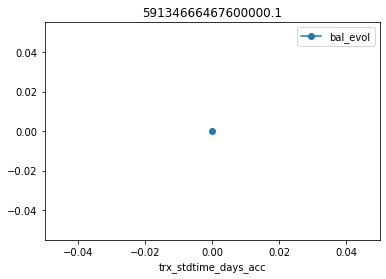

59134666467600000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
61,FRMLN,Individual Business or Agriculture Loan,0,1. Starting balance (today),0.0,0.0,0.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
61,FRMLN,Individual Business or Agriculture Loan,0,1. Starting balance (today),0.0,0.0,0.0
73,FRMLN,Individual Business or Agriculture Loan,35,1. Starting balance (today),0.0,0.0,0.0
1305,FRMLN,Individual Business or Agriculture Loan,39,3. Payments,2800.0,-2800.0,0.0
865,FRMLN,Individual Business or Agriculture Loan,59,2. New borrowing,9625.0,9625.0,9625.0
1076,FRMLN,Individual Business or Agriculture Loan,85,3. Payments,500.0,9125.0,9625.0
1400,FRMLN,Individual Business or Agriculture Loan,106,3. Payments,300.0,8825.0,9625.0
1107,FRMLN,Individual Business or Agriculture Loan,127,3. Payments,200.0,8625.0,9625.0
1090,FRMLN,Individual Business or Agriculture Loan,134,3. Payments,500.0,8125.0,9625.0
609,FRMLN,Individual Business or Agriculture Loan,164,3. Payments,100.0,8025.0,9625.0
673,FRMLN,Individual Business or Agriculture Loan,171,3. Payments,50.0,7975.0,9625.0


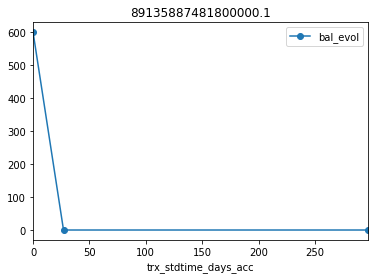

89135887481800000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
241,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),600.0,600.0,600.0
1493,INFGRP,Borrowing from an informal Group,27,3. Payments,600.0,0.0,600.0
242,INFGRP,Borrowing from an informal Group,297,7. Closing Balance--End of last DQ,0.0,0.0,600.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
241,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),600.0,600.0,600.0
1493,INFGRP,Borrowing from an informal Group,27,3. Payments,600.0,0.0,600.0
242,INFGRP,Borrowing from an informal Group,297,7. Closing Balance--End of last DQ,0.0,0.0,600.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


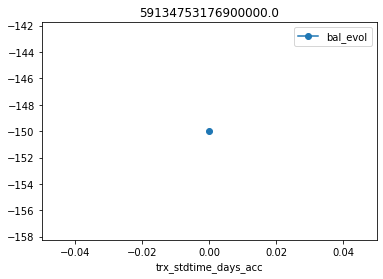

59134753176900000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1425,FRMLN,Individual Business or Agriculture Loan,0,3. Payments,150.0,-150.0,150.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1425,FRMLN,Individual Business or Agriculture Loan,0,3. Payments,150.0,-150.0,150.0
43,FRMLN,Individual Business or Agriculture Loan,1,1. Starting balance (today),5450.0,5450.0,5450.0
666,FRMLN,Individual Business or Agriculture Loan,14,3. Payments,450.0,5000.0,5450.0
1032,FRMLN,Individual Business or Agriculture Loan,49,3. Payments,500.0,4500.0,5450.0
1033,FRMLN,Individual Business or Agriculture Loan,98,3. Payments,500.0,4000.0,5450.0
681,FRMLN,Individual Business or Agriculture Loan,133,3. Payments,1000.0,3000.0,5450.0
1034,FRMLN,Individual Business or Agriculture Loan,308,3. Payments,3000.0,0.0,5450.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


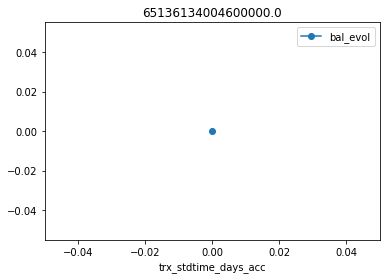

65136134004600000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
291,INFGRP,Borrowing from an informal Group,0,7. Closing Balance--End of last DQ,0.0,0.0,0.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
291,INFGRP,Borrowing from an informal Group,0,7. Closing Balance--End of last DQ,0.0,0.0,0.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


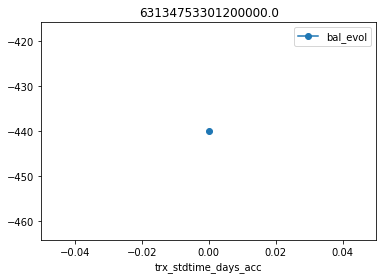

63134753301200000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1010,INFGRP,Borrowing from an informal Group,0,3. Payments,440.0,-440.0,440.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1010,INFGRP,Borrowing from an informal Group,0,3. Payments,440.0,-440.0,440.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


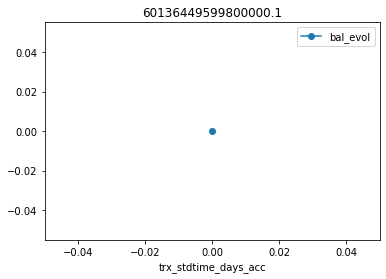

60136449599800000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
456,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),0.0,0.0,0.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
456,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),0.0,0.0,0.0
101,INFGRP,Borrowing from an informal Group,174,5. Interest accruing,200.0,1200.0,1000.0
802,INFGRP,Borrowing from an informal Group,174,2. New borrowing,1000.0,1000.0,1000.0
1242,INFGRP,Borrowing from an informal Group,174,3. Payments,200.0,1000.0,1000.0
542,INFGRP,Borrowing from an informal Group,234,5. Interest accruing,200.0,1200.0,1000.0
1114,INFGRP,Borrowing from an informal Group,234,3. Payments,500.0,700.0,1000.0
503,INFGRP,Borrowing from an informal Group,380,7. Closing Balance--End of last DQ,700.0,700.0,1000.0


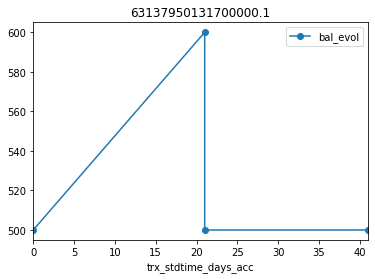

63137950131700000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
989,INFGRP,Borrowing from an informal Group,0,2. New borrowing,500.0,500.0,500.0
325,INFGRP,Borrowing from an informal Group,21,5. Interest accruing,100.0,600.0,500.0
1095,INFGRP,Borrowing from an informal Group,21,3. Payments,100.0,500.0,500.0
187,INFGRP,Borrowing from an informal Group,41,7. Closing Balance--End of last DQ,500.0,500.0,500.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
989,INFGRP,Borrowing from an informal Group,0,2. New borrowing,500.0,500.0,500.0
325,INFGRP,Borrowing from an informal Group,21,5. Interest accruing,100.0,600.0,500.0
1095,INFGRP,Borrowing from an informal Group,21,3. Payments,100.0,500.0,500.0
187,INFGRP,Borrowing from an informal Group,41,7. Closing Balance--End of last DQ,500.0,500.0,500.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


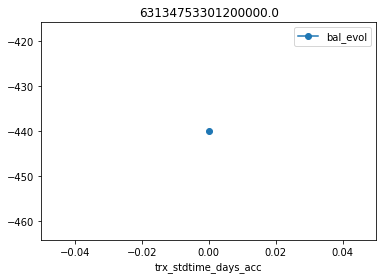

63134753301200000.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1010,INFGRP,Borrowing from an informal Group,0,3. Payments,440.0,-440.0,440.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
1010,INFGRP,Borrowing from an informal Group,0,3. Payments,440.0,-440.0,440.0


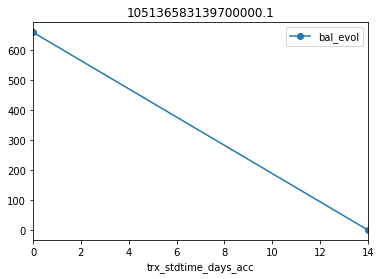

105136583139700000.1


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
522,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),660.0,660.0,660.0
1324,INFGRP,Borrowing from an informal Group,14,3. Payments,660.0,0.0,660.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
522,INFGRP,Borrowing from an informal Group,0,1. Starting balance (today),660.0,660.0,660.0
1324,INFGRP,Borrowing from an informal Group,14,3. Payments,660.0,0.0,660.0
222,INFGRP,Borrowing from an informal Group,27,5. Interest accruing,100.0,1100.0,1000.0
983,INFGRP,Borrowing from an informal Group,27,2. New borrowing,1000.0,1000.0,1000.0
336,INFGRP,Borrowing from an informal Group,41,5. Interest accruing,20.0,220.0,200.0
949,INFGRP,Borrowing from an informal Group,41,3. Payments,1100.0,-880.0,200.0
951,INFGRP,Borrowing from an informal Group,41,2. New borrowing,200.0,200.0,200.0
1315,INFGRP,Borrowing from an informal Group,62,3. Payments,220.0,-1100.0,200.0
502,INFGRP,Borrowing from an informal Group,125,5. Interest accruing,150.0,1650.0,1500.0
950,INFGRP,Borrowing from an informal Group,125,2. New borrowing,1500.0,1500.0,1500.0


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left == right == 150.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


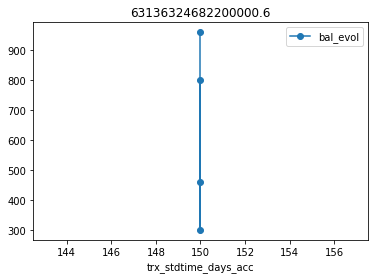

63136324682200000.6


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
389,INFGRP,Borrowing from an informal Group,150,4. Any known fees,160.0,960.0,800.0
845,INFGRP,Borrowing from an informal Group,150,3. Payments,500.0,460.0,800.0
1266,INFGRP,Borrowing from an informal Group,150,3. Payments,160.0,300.0,800.0
1343,INFGRP,Borrowing from an informal Group,150,2. New borrowing,800.0,800.0,800.0


,trx_family_code,trx_type_desc,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
919,INFGRP,Borrowing from an informal Group,0,2. New borrowing,200.0,200.0,200.0
867,INFGRP,Borrowing from an informal Group,15,3. Payments,100.0,100.0,200.0
855,INFGRP,Borrowing from an informal Group,59,3. Payments,100.0,0.0,200.0
1251,INFGRP,Borrowing from an informal Group,83,2. New borrowing,200.0,200.0,200.0
539,INFGRP,Borrowing from an informal Group,83,5. Interest accruing,50.0,250.0,200.0
634,INFGRP,Borrowing from an informal Group,83,3. Payments,50.0,200.0,200.0
1376,INFGRP,Borrowing from an informal Group,89,3. Payments,40.0,0.0,200.0
1230,INFGRP,Borrowing from an informal Group,89,2. New borrowing,200.0,200.0,200.0
51,INFGRP,Borrowing from an informal Group,89,5. Interest accruing,40.0,240.0,200.0
837,INFGRP,Borrowing from an informal Group,89,3. Payments,200.0,40.0,200.0


In [137]:
count = 0
for i in range(0,10):
    acc=random.choice(df[df["start_bal"]<1000]["new_account_ids"].unique())
    df[df["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc").plot(x="trx_stdtime_days_acc",y="bal_evol", title = acc,marker="o")
    plt.show()
    print(acc)
    display(df[df["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])
    display(df[df["account_ids"]==acc[:-2]].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])

In [138]:
df.to_csv("diaries_trx_trunc_loans_start_bal.csv")